In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [2]:
get_ipython().run_cell_magic('capture', '', "\n#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n\n!python3 -m pip install pandas\n!pip install chardet\n!pip install db-dtypes\n!pip install catboost\n")

In [3]:
#Importing Libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
import csv
import numpy as np

In [5]:
from google.cloud import bigquery
import scipy as sp
import statsmodels as sm
import statistics as stat
import sklearn
import patsy as pt
import chardet as ch
import click as cl
import cytoolz as cz
import dask
import decorator as dr
#import pyjson5 as py
import jsonschema as js
import tables
import db_dtypes
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
global df3

In [7]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [8]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [9]:
query_job1 = bigquery_client.query(query)
query_job1

QueryJob<project=ironhacks-data, location=US, id=6bd0ad69-1f2e-40b7-a6bf-6f503f95a692>

In [10]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [11]:
query_job2 = bigquery_client.query(query)
query_job2

QueryJob<project=ironhacks-data, location=US, id=7cf009e3-ad0e-4702-8791-27a90eea04b0>

In [12]:
!pip install db-dtypes
df1 = query_job2.to_dataframe()
df1.uu_id.nunique()

525

In [13]:
!pip install db-dtypes
df2 = query_job1.to_dataframe()
df2.uu_id.nunique()

525

In [14]:
df3 = pd.merge(df1,df2, on= ["uu_id","countyfips","tract","tract_name"])

In [15]:
#Expanding timeperiod to day, month and year
df3["time"] = pd.to_datetime(df3["timeperiod"], format= '%Y%m%d', errors = "coerce")
df3 =df3.drop("timeperiod", axis = 1)
df3["month"] = df3["time"].dt.month
df3["day"] = df3["time"].dt.day
str_col = ["tract_name", 'top_category_employer1', 'top_category_employer2',
       'top_category_employer3',"time"]
df3["uu_id_enc"] = df3["uu_id"].astype('category').cat.codes
#Encoding Strings
for col in str_col :
    df3[col] = df3[col].astype('category').cat.codes
int_col = list(set(df3.columns) -set(str_col)-set(["uu_id"]))
#dropping and replacing Nan, NaT   
df3 =df3.astype(str)
df3 = df3[df3["uu_id"] != np.nan]
df3 = df3.replace('NaT', np.nan)
df3 = df3.replace(str(np.nan),str(0))
#df3 = df3.dropna(subset = ["uu_id"], inplace=True)
for col in df3.columns:
    df3[col] = df3[col].str.replace(str("<NA>"),"0")
for col in int_col:
    df3[col] =df3[col].astype(float)
df = df3.copy()
df3.uu_id.nunique()

525

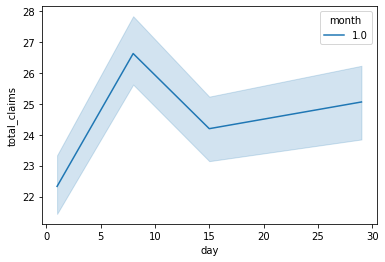

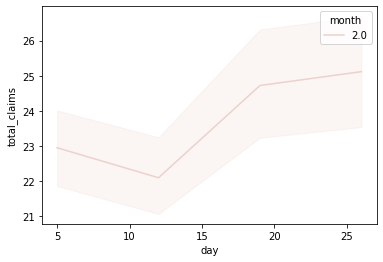

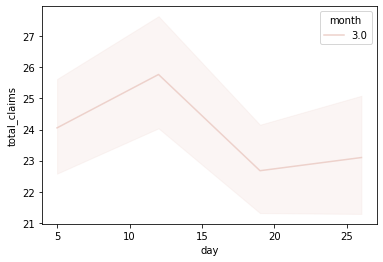

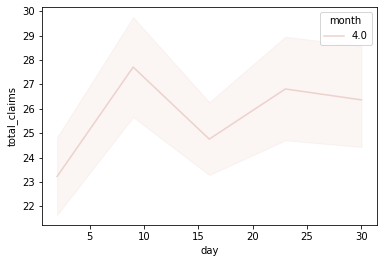

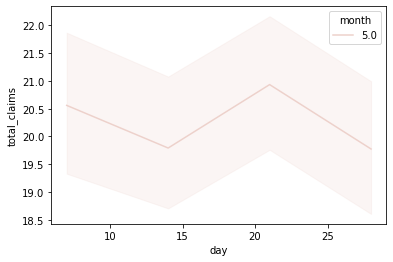

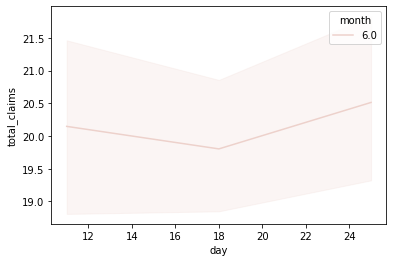

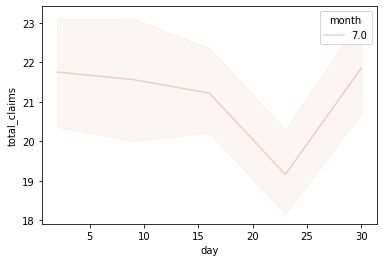

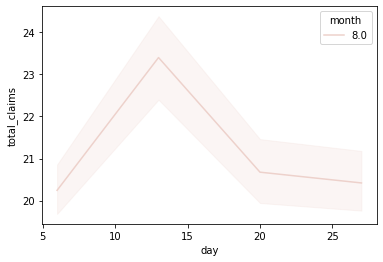

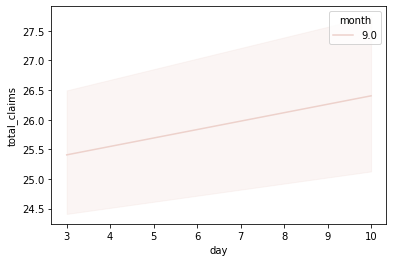

In [16]:
for k in range(1,10):
    temp = df3[df3.month ==k]
    ax= sns.lineplot( x= "day", y= "total_claims", hue = "month", data =temp )
    plt.show()

In [17]:
df4 = df3.corr()
df4

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_5460/3822703957.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4 = df3.corr()


,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,month,day,uu_id_enc
week_number,1.000000,-0.001015,-0.007765,-0.054817,0.019532,0.003564,-0.073129,0.003422,-0.006047,-0.033730,...,-0.013168,-0.057827,0.004888,NaN,0.010290,-0.008640,0.028205,0.994291,0.025037,-0.006156
countyfips,-0.001015,1.000000,0.014993,-0.011242,-0.002837,-0.003048,-0.005792,-0.019259,0.009003,-0.021396,...,-0.015725,0.010962,0.000043,NaN,-0.009349,-0.043639,-0.145017,-0.000952,0.000457,-0.015962
tract,-0.007765,0.014993,1.000000,-0.041477,0.038854,-0.001890,-0.043448,-0.022050,0.005409,-0.020104,...,0.000705,-0.015516,-0.009342,NaN,-0.025992,0.007572,0.080756,-0.007176,-0.007065,0.063204
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,0.037281,0.594516,0.176601,NaN,0.203242,0.420222,-0.063042,-0.052776,-0.020447,-0.001522
edu_8th_or_less,0.019532,-0.002837,0.038854,0.069029,1.000000,-0.001538,0.013054,-0.006682,-0.002748,0.039022,...,0.013050,0.012987,0.031040,NaN,0.032625,0.057438,0.028467,0.020405,-0.008325,-0.011235
edu_grades_9_11,0.003564,-0.003048,-0.001890,0.267877,-0.001538,1.000000,0.063023,0.017355,-0.001633,0.205276,...,0.040969,0.123855,0.062479,NaN,0.081431,0.126348,-0.013874,0.003867,-0.003019,-0.019018
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,0.004730,0.470553,0.134671,NaN,0.132365,0.294847,-0.090832,-0.070333,-0.027185,-0.005291
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.016314,0.291321,0.082710,NaN,0.099779,0.230607,0.019414,0.003506,-0.001779,0.020953
edu_unknown,-0.006047,0.009003,0.005409,0.107267,-0.002748,-0.001633,0.011754,0.006395,1.000000,0.052286,...,-0.001464,0.051318,0.008542,NaN,0.076620,0.024064,-0.020837,-0.005783,-0.002308,0.004989
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,0.017234,0.484824,0.108992,NaN,0.116942,0.302491,-0.071086,-0.032995,-0.009440,-0.000822


In [18]:
df4[df4.total_claims>0.2]

,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage,month,day,uu_id_enc
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,0.037281,0.594516,0.176601,NaN,0.203242,0.420222,-0.063042,-0.052776,-0.020447,-0.001522
edu_grades_9_11,0.003564,-0.003048,-0.001890,0.267877,-0.001538,1.000000,0.063023,0.017355,-0.001633,0.205276,...,0.040969,0.123855,0.062479,NaN,0.081431,0.126348,-0.013874,0.003867,-0.003019,-0.019018
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,0.004730,0.470553,0.134671,NaN,0.132365,0.294847,-0.090832,-0.070333,-0.027185,-0.005291
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.016314,0.291321,0.082710,NaN,0.099779,0.230607,0.019414,0.003506,-0.001779,0.020953
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,0.017234,0.484824,0.108992,NaN,0.116942,0.302491,-0.071086,-0.032995,-0.009440,-0.000822
gender_male,-0.038832,-0.025299,-0.025640,0.738217,0.050745,0.169898,0.582283,0.376703,0.043780,0.650736,...,0.023153,0.405605,0.123161,NaN,0.132695,0.380081,-0.023995,-0.036812,-0.022545,-0.002551
race_black,-0.057827,0.010962,-0.015516,0.594516,0.012987,0.123855,0.470553,0.291321,0.051318,0.484824,...,0.005224,1.000000,0.027192,NaN,0.015240,-0.133331,-0.180280,-0.059313,0.018327,-0.003819
race_other,0.010290,-0.009349,-0.025992,0.203242,0.032625,0.081431,0.132365,0.099779,0.076620,0.116942,...,-0.002411,0.015240,0.045787,NaN,1.000000,0.043658,0.005774,0.011884,-0.015563,0.006683
race_white,-0.008640,-0.043639,0.007572,0.420222,0.057438,0.126348,0.294847,0.230607,0.024064,0.302491,...,0.001129,-0.133331,0.033160,NaN,0.043658,1.000000,0.148197,-0.003646,-0.053829,-0.003862


sns.heatmap(df3.drop([k for k in str_col], axis=1), annot =True)

total_claims


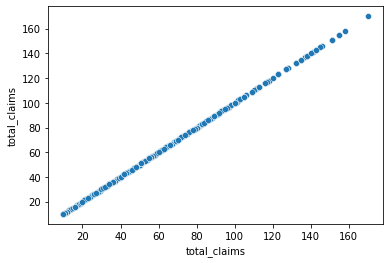

edu_grades_9_11


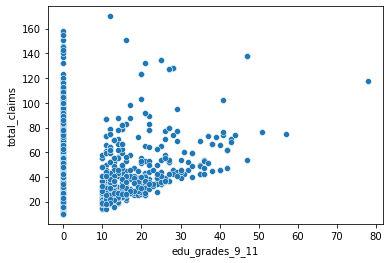

edu_hs_grad_equiv


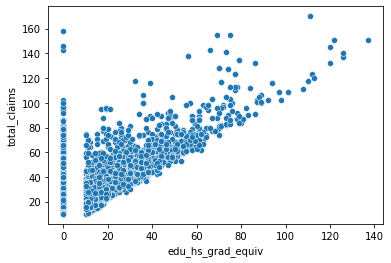

edu_post_hs


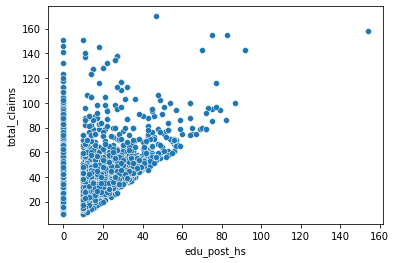

gender_female


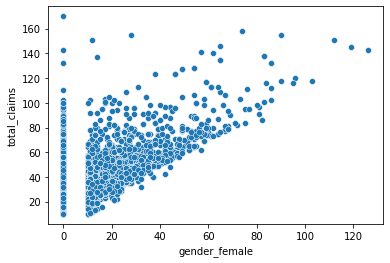

gender_male


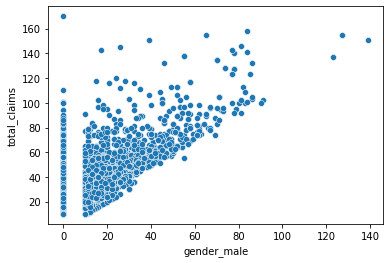

race_black


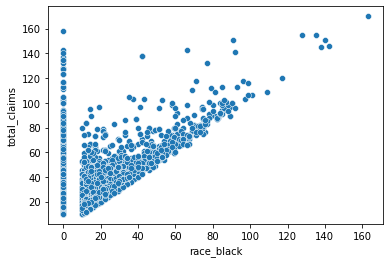

race_other


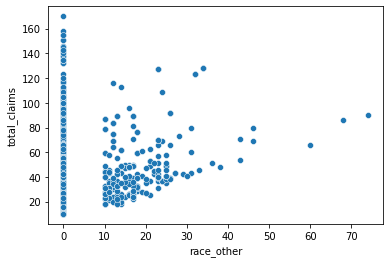

race_white


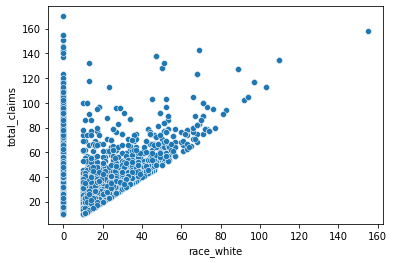

In [19]:
features =df4[df4.total_claims>0.2].index
for feature in features:
    print(feature)
    ax= sns.scatterplot(x = df3[feature], y = df3["total_claims"])
    plt.show()

total_claims


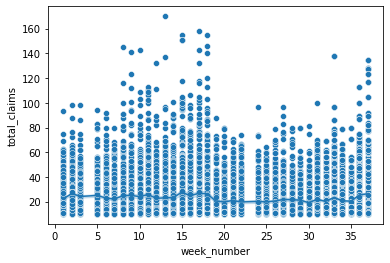

edu_grades_9_11


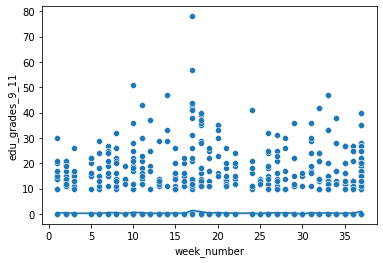

edu_hs_grad_equiv


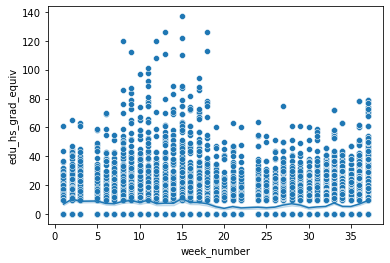

edu_post_hs


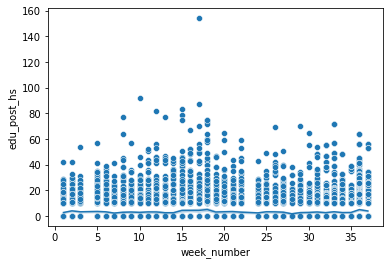

gender_female


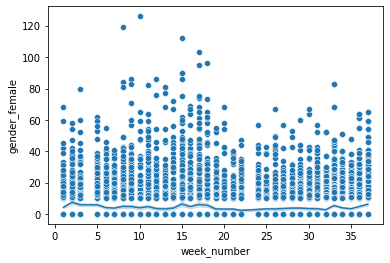

gender_male


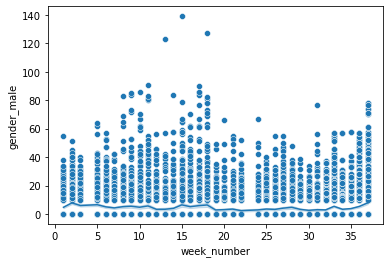

race_black


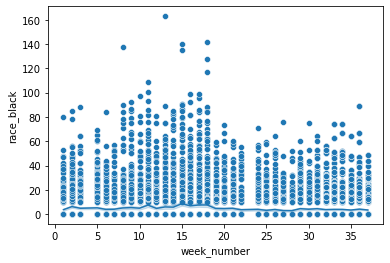

race_other


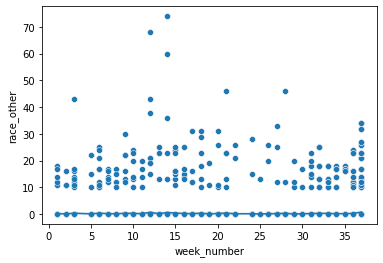

race_white


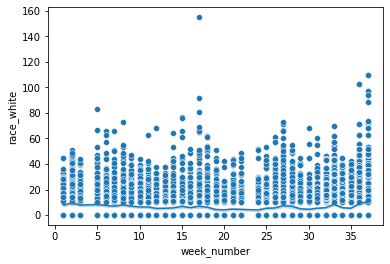

In [20]:
features =df4[df4.total_claims>0.2].index
for feature in features:
    print(feature)
    ax= sns.scatterplot(y = df3[feature], x = "week_number", data = df3)
    ax= sns.lineplot(y = df3[feature], x = "week_number", data = df3)
    plt.show()

In [21]:
df3 = df.copy()
df3.columns

Index(['uu_id', 'week_number', 'countyfips', 'tract', 'tract_name',
       'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage',
       'time', 'month', 'day', 'uu_id_enc'],
      dtype='object')

In [22]:
races = ['race_black', 'race_other', 'race_white']
#for j in races:
g = (sum([df3[k] for k in races]))
df3["normalized_"+ str("races") ] = g
df3["normalized_"+ str("races") ].unique()

array([ 11.,   0.,  15.,  14.,  20.,  17.,  10.,  32.,  34.,  22.,  25.,
        46.,  60.,  29.,  42.,  16.,  12.,  21.,  39.,  13.,  57.,  55.,
        43.,  18.,  92.,  24.,  19.,  82.,  90., 142.,  47.,  33.,  75.,
       135.,  31.,  26.,  73.,  28., 109.,  37.,  23.,  27.,  30.,  38.,
        41.,  52.,  45.,  71.,  61.,  40.,  44.,  84.,  36.,  35.,  53.,
        89.,  70.,  64.,  63.,  59.,  49.,  68.,  51.,  76.,  58.,  65.,
        50.,  79.,  48.,  56.,  69.,  62.,  72.,  74.,  54.,  66.,  85.,
       105., 101., 140.,  83.,  87.,  96., 103.,  97.,  77., 138.,  67.,
        81.,  86., 117., 111.,  88.,  91., 128.,  93., 108., 155., 163.,
        99.,  78.,  80., 107., 100.,  95., 112., 110.,  94.])

In [23]:
ed = ['edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs']
for j in ed:
    df3["normalized_"+ str("education") ] = sum([df3[k] for k in ed])

In [24]:
gen = [ 'gender_female', 'gender_male']
for j in gen:
    df3["normalized_"+ str("gender") ] = sum([df3[k] for k in gen])

In [25]:
df3["sum"] = (df3["normalized_"+ str("education") ]+df3["normalized_"+ str("races") ]+df3["normalized_"+ str("gender") ])

In [26]:
def opt_features(x):
    df3["opt_var"]= (x[3]*df3["normalized_"+ str("education") ]**x[0]+x[4]*df3["normalized_"+ str("races") ]**x[1]+x[5]*df3["normalized_"+ str("gender") ]**x[2]+x[6])
    df4 =df3.corr()
    corr = -df4.loc["opt_var","total_claims"]
    return corr
import scipy   
op = scipy.optimize.minimize(opt_features, [1]*7,method="SLSQP") 
op

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_5460/3549868753.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4 =df3.corr()


     fun: -0.9391144116847102
     jac: array([-4.72836196e-04, -2.24843621e-04,  1.12153590e-04, -2.12490559e-05,
       -8.30739737e-05,  3.21738422e-04,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 229
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([1.03927724, 1.33562453, 1.35915665, 2.25884102, 0.35523893,
       0.23445896, 1.        ])

In [27]:
def opt_features2(x):
    #corr = -df4.loc["opt_var1","total_claims"]
    df3["opt_var2"]=x[0]*df3["opt_var"]+x[1]*df3["week_number"]
    df3["error"]= df3["total_claims"]-df3["opt_var2"]
    return abs(df3["error"]).sum()
cons = ({'type': 'ineq',
       'fun': lambda x:  opt_features2(x)
       },
        {'type': 'ineq',
       'fun': lambda x:  -opt_features2(x)
       },
        {'type': 'ineq',
       'fun': lambda x:  x[1]-1
       })
op2 = scipy.optimize.minimize(opt_features2, [1]*7,method="SLSQP", constraints = cons) 
op2

     fun: 813858.1207688724
     jac: array([812211.1171875, 337886.       ,      0.       ,      0.       ,
            0.       ,      0.       ,      0.       ])
 message: 'Positive directional derivative for linesearch'
    nfev: 8
     nit: 5
    njev: 1
  status: 8
 success: False
       x: array([1., 1., 1., 1., 1., 1., 1.])

In [28]:
df3["opt_var2"]=df3["opt_var"]+df3["opt_var2"]

In [29]:
df4 = df3.corr()
df4

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_5460/3822703957.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4 = df3.corr()


,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
week_number,1.000000,-0.001015,-0.007765,-0.054817,0.019532,0.003564,-0.073129,0.003422,-0.006047,-0.033730,...,0.994291,0.025037,-0.006156,-0.048913,-0.054185,-0.039989,-0.052532,-0.048890,0.030031,-0.145223
countyfips,-0.001015,1.000000,0.014993,-0.011242,-0.002837,-0.003048,-0.005792,-0.019259,0.009003,-0.021396,...,-0.000952,0.000457,-0.015962,-0.024707,-0.015422,-0.025740,-0.024637,-0.024650,-0.024748,0.027384
tract,-0.007765,0.014993,1.000000,-0.041477,0.038854,-0.001890,-0.043448,-0.022050,0.005409,-0.020104,...,-0.007176,-0.007065,0.063204,-0.010364,-0.045897,-0.025235,-0.030135,-0.034986,-0.035626,0.033948
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,-0.052776,-0.020447,-0.001522,0.790695,0.897792,0.805103,0.922510,0.939114,0.935487,-0.888089
edu_8th_or_less,0.019532,-0.002837,0.038854,0.069029,1.000000,-0.001538,0.013054,-0.006682,-0.002748,0.039022,...,0.020405,-0.008325,-0.011235,0.056605,0.006240,0.049529,0.042334,0.034968,0.036536,-0.029560
edu_grades_9_11,0.003564,-0.003048,-0.001890,0.267877,-0.001538,1.000000,0.063023,0.017355,-0.001633,0.205276,...,0.003867,-0.003019,-0.019018,0.198873,0.267673,0.206088,0.248195,0.266271,0.266751,-0.259220
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,-0.070333,-0.027185,-0.005291,0.594066,0.817667,0.627753,0.752760,0.787297,0.782110,-0.762949
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.003506,-0.001779,0.020953,0.405391,0.578977,0.413722,0.514986,0.541477,0.542151,-0.537039
edu_unknown,-0.006047,0.009003,0.005409,0.107267,-0.002748,-0.001633,0.011754,0.006395,1.000000,0.052286,...,-0.005783,-0.002308,0.004989,0.068465,0.012197,0.052776,0.049885,0.040827,0.040380,-0.022586
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,-0.032995,-0.009440,-0.000822,0.608157,0.676363,0.904675,0.822653,0.775079,0.772994,-0.759400


In [30]:
df4[abs(df4.total_claims)>0.5]
#df4.loc["ult","total_claims"]

,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,-0.052776,-0.020447,-0.001522,0.790695,0.897792,0.805103,0.922510,0.939114,0.935487,-0.888089
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,-0.070333,-0.027185,-0.005291,0.594066,0.817667,0.627753,0.752760,0.787297,0.782110,-0.762949
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.003506,-0.001779,0.020953,0.405391,0.578977,0.413722,0.514986,0.541477,0.542151,-0.537039
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,-0.032995,-0.009440,-0.000822,0.608157,0.676363,0.904675,0.822653,0.775079,0.772994,-0.759400
gender_male,-0.038832,-0.025299,-0.025640,0.738217,0.050745,0.169898,0.582283,0.376703,0.043780,0.650736,...,-0.036812,-0.022545,-0.002551,0.606272,0.688769,0.912246,0.829481,0.783864,0.781382,-0.765767
race_black,-0.057827,0.010962,-0.015516,0.594516,0.012987,0.123855,0.470553,0.291321,0.051318,0.484824,...,-0.059313,0.018327,-0.003819,0.670411,0.546791,0.489177,0.626942,0.625488,0.621388,-0.604602
normalized_races,-0.048913,-0.024707,-0.010364,0.790695,0.056605,0.198873,0.594066,0.405391,0.068465,0.608157,...,-0.046182,-0.027418,-0.004696,1.000000,0.719309,0.668324,0.876010,0.844055,0.840822,-0.824220
normalized_education,-0.054185,-0.015422,-0.045897,0.897792,0.006240,0.267673,0.817667,0.578977,0.012197,0.676363,...,-0.051906,-0.022683,0.003102,0.719309,1.000000,0.751417,0.911358,0.956102,0.952537,-0.933356
normalized_gender,-0.039989,-0.025740,-0.025235,0.805103,0.049529,0.206088,0.627753,0.413722,0.052776,0.904675,...,-0.038459,-0.017745,-0.001875,0.668324,0.751417,1.000000,0.909304,0.858039,0.855521,-0.839424
sum,-0.052532,-0.024637,-0.030135,0.922510,0.042334,0.248195,0.752760,0.514986,0.049885,0.822653,...,-0.050152,-0.024817,-0.001318,0.876010,0.911358,0.909304,1.000000,0.983388,0.979974,-0.960823


In [31]:
features =df4[abs(df4.total_claims)>0.6].index
features

Index(['total_claims', 'edu_hs_grad_equiv', 'gender_female', 'gender_male',
       'normalized_races', 'normalized_education', 'normalized_gender', 'sum',
       'opt_var', 'opt_var2', 'error'],
      dtype='object')

total_claims (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


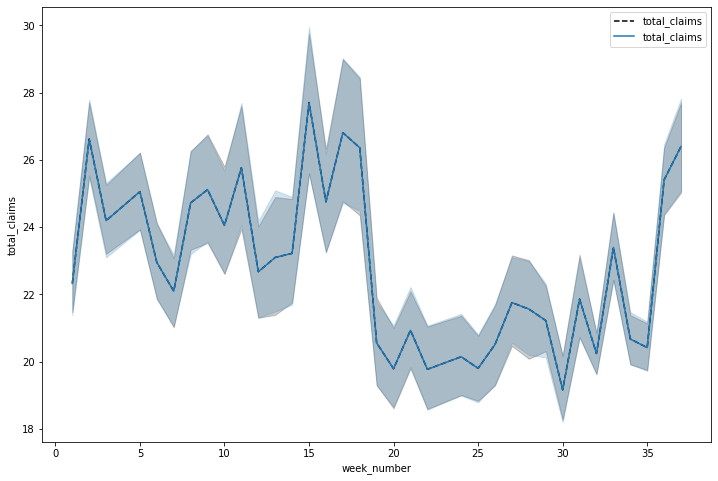

edu_hs_grad_equiv (1.0, 0.4980392156862745, 0.054901960784313725)


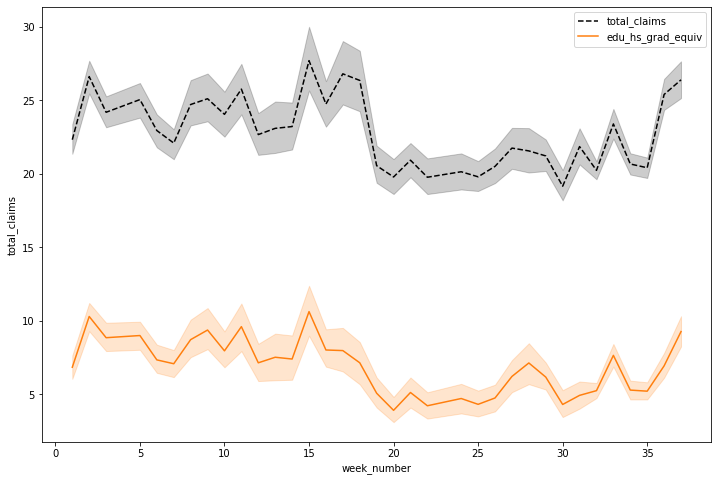

gender_female (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)


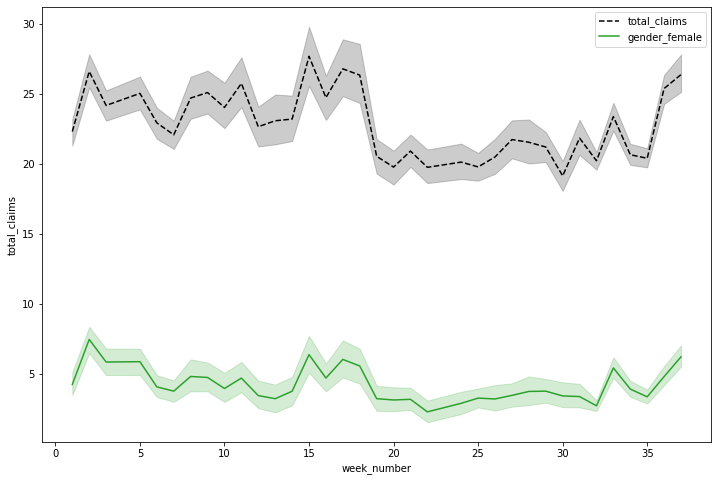

gender_male (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)


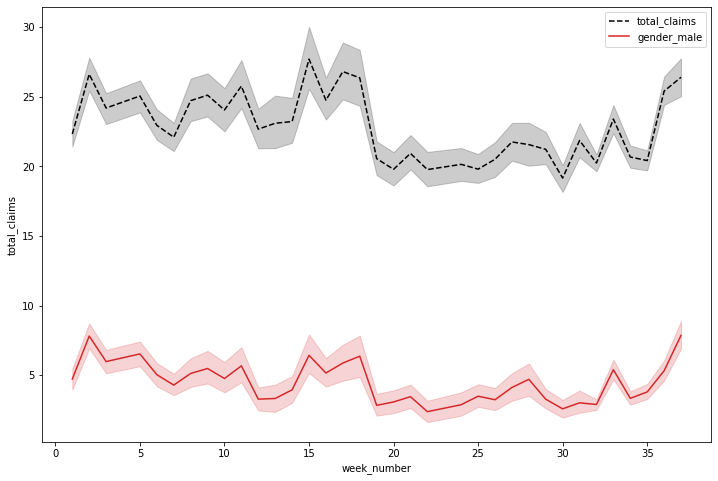

normalized_races (0.5803921568627451, 0.403921568627451, 0.7411764705882353)


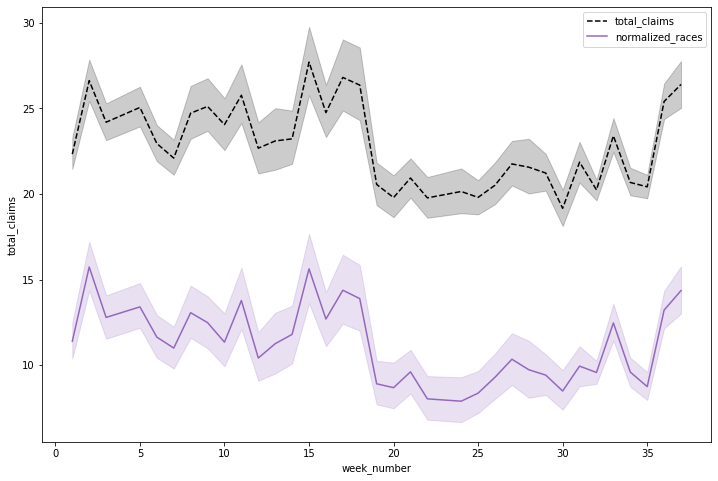

normalized_education (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)


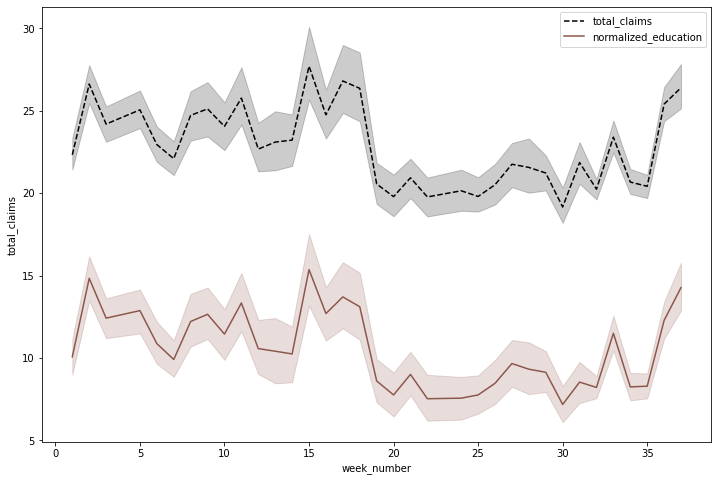

normalized_gender (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)


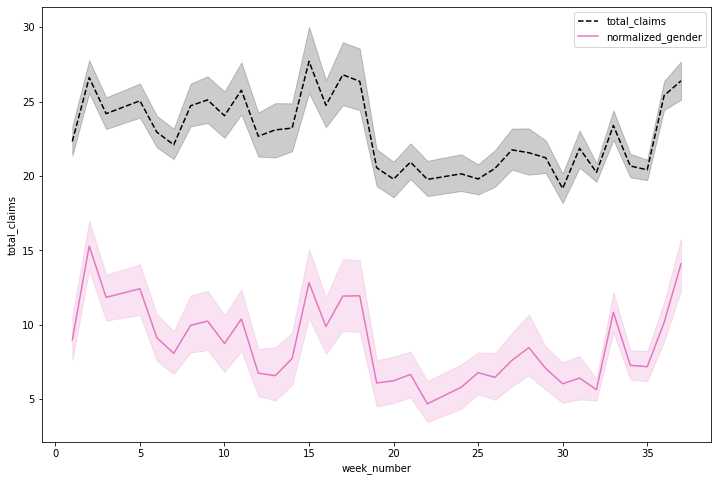

sum (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)


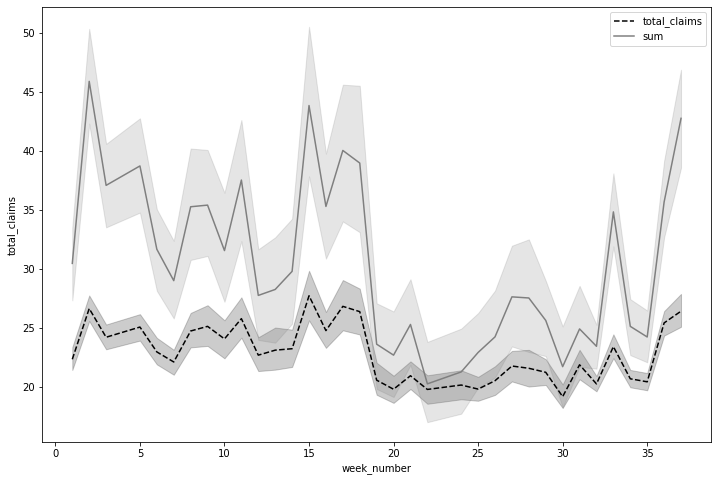

opt_var (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)


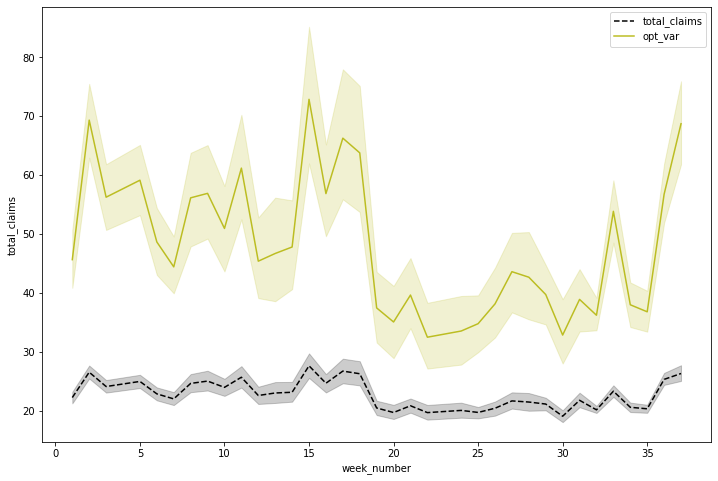

opt_var2 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)


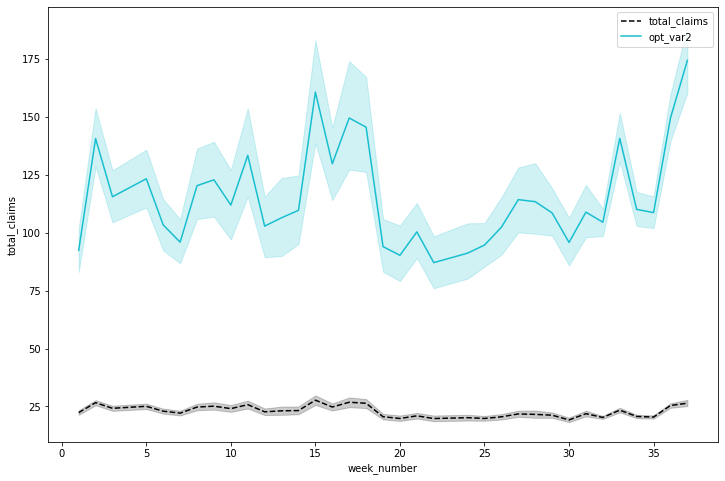

error (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


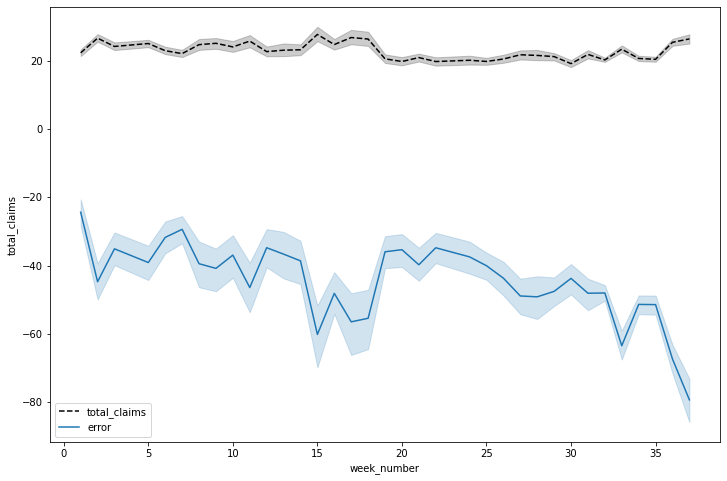

In [32]:
import itertools
colors = itertools.cycle(sns.color_palette("tab10"))
for feature in features:
    fig, ax = plt.subplots(figsize=(12,8)) 
    c = next(colors)
    print(feature, c)
    #sns.scatterplot(x= feature, y = "week_number", data =df3)
    sns.lineplot(y= "total_claims", x = "week_number", data =df3, color = "black", label = "total_claims", linestyle= "--")
    sns.lineplot(y= feature, x = "week_number", data =df3, color = c, label = feature)
    plt.show()

error (1.0, 0.4980392156862745, 0.054901960784313725)


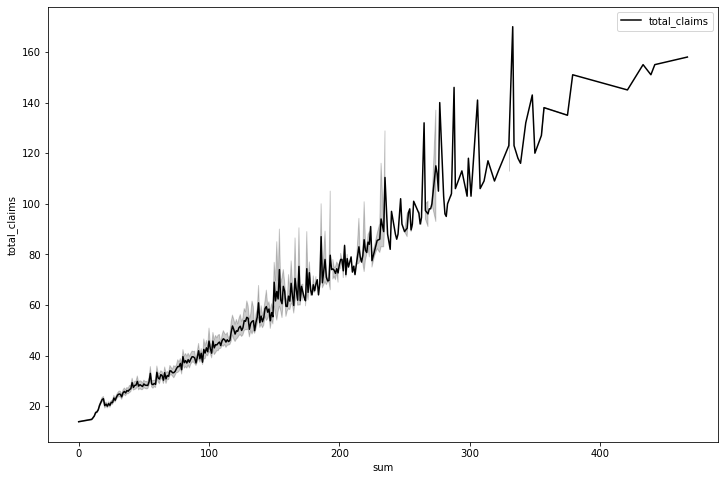

In [33]:
fig, ax = plt.subplots(figsize=(12,8)) 
c = next(colors)
print(feature, c)
#sns.scatterplot(x= feature, y = "week_number", data =df3)
sns.lineplot(y= "total_claims", x = "sum", data =df3, color = "black", label = "total_claims")
#sns.lineplot(y= feature, x = "week_number", data =df3, color = c, label = feature)
plt.show()

In [34]:
temp = df3[[k for k in features]]
temp

,total_claims,edu_hs_grad_equiv,gender_female,gender_male,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
0,22.0,14.0,0.0,0.0,11.0,14.0,0.0,25.0,44.816011,105.632023,-38.816011
1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,9.000000,2.000000
2,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,37.000000,-25.000000
3,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,13.000000,-1.000000
4,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...
16828,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,12.000000,0.000000
16829,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8.000000,3.000000
16830,16.0,10.0,0.0,0.0,0.0,10.0,0.0,10.0,25.726515,82.453030,-40.726515
16831,23.0,19.0,0.0,0.0,0.0,19.0,0.0,19.0,49.179821,107.359642,-35.179821


In [35]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as rg
sc = StandardScaler()

In [36]:
import statsmodels.api as sm
from statsmodels import tsa

In [37]:
mod = sm.tsa.statespace.SARIMAX(np.array(df3["total_claims"]),
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21451D+00    |proj g|=  1.26074D-01

At iterate    5    f=  4.13686D+00    |proj g|=  6.39372D-02

At iterate   10    f=  4.12913D+00    |proj g|=  2.73443D-02

At iterate   15    f=  4.07252D+00    |proj g|=  2.00865D-01

At iterate   20    f=  4.00887D+00    |proj g|=  3.51354D-02

At iterate   25    f=  4.00872D+00    |proj g|=  4.68111D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     46      1     0     0   

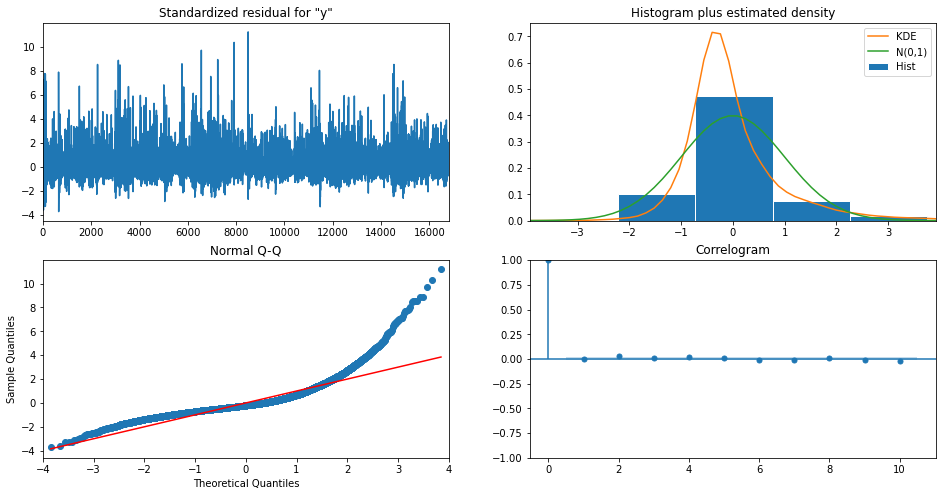

In [38]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

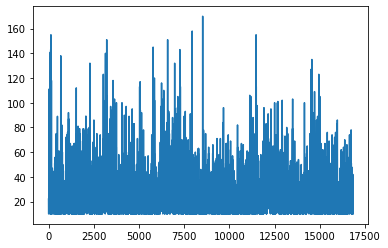

In [39]:
pred = results.get_prediction(start=1, dynamic=False)
pred_ci = pred.conf_int()
y = df3["total_claims"]
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Total Claims')
plt.legend()
plt.show()

[22.68772391  9.46879592 11.02202745 ... 17.06863642 17.17870813
 17.91750865]


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

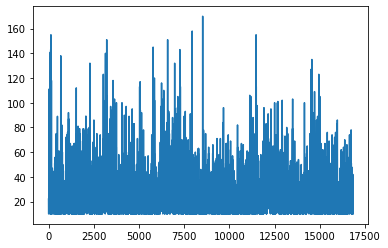

In [40]:
pred = results.get_prediction(start=1, dynamic=False)
pred_ci = pred.conf_int()
y = df3["total_claims"]
ax = y.plot(label='observed')
print(pred.predicted_mean)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Total Claims')
plt.legend()
plt.show()

[22.68772391  9.46879592 11.02202745 ... 17.06863642 17.17870813
 17.91750865]


ValueError: Length of values (16832) does not match length of index (16833)

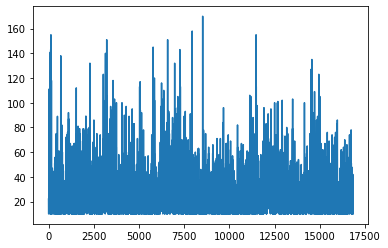

In [41]:
pred = results.get_prediction(start=1, dynamic=False)
pred_ci = pred.conf_int()
y = df3["total_claims"]
ax = y.plot(label='observed')
print(pred.predicted_mean)
df3["pred"]=pred.predicted_mean
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Total Claims')
plt.legend()
plt.show()